<h1 align='center'><strong>Webscrapping HICP and real GDP from European Central Bank</strong></h1>

------

In [1]:
# Import Libraries
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
import re
import regex
from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns

try:
    # For Python 3.0 and later
    from urllib.request import urlopen
except ImportError:
    # Fall back to Python 2's urllib2
    from urllib2 import urlopen
    
%matplotlib inline    

In [2]:
# For black background and saving figures

sns.set(style="whitegrid", context='paper')
label_size = 30

for i in ['text.color','axes.labelcolor','xtick.color','ytick.color','axes.edgecolor']:
    plt.rcParams[i] = 'black'
    
for i in ['xtick.labelsize', 'ytick.labelsize', 'axes.titlesize', 'axes.labelsize']:
    plt.rcParams[i] = label_size

In [3]:
# Specify the url
# Query the website and return the html to the variable ‘page’
url = "https://www.ecb.europa.eu/mopo/strategy/ecana/html/table.en.html"
response = requests.get(url)

In [4]:
# If the access was successful, you should see the following output <Response [200]>
response

<Response [200]>

In [5]:
# IMF World Real GDP Growth Forecast
# Inspiration for how I will display the ECB forecast later
Image(url="http://jaredbernsteinblog.com/wp-content/uploads/2016/06/imf_growth.png")

In [6]:
# parse the html using beautiful soup and store in variable `soup`
soup = BeautifulSoup(response.text, "html.parser")

a = []
b = []
for row in soup.select('tbody tr'):
    row_text = [x.get_text().strip() for x in row.find_all('td')] # Starts from March 2019 and goes across row
    row_text = ', '.join(row_text) # join together
    row_th = [y.get_text().strip() for y in row.find_all('th')] 
    row_th = ', '.join(row_th)
    a.append(row_text)
    b.append(row_th)

In [7]:
## Dates before 2014 have a different structure on the website

numb_list = [i for i in range(len(a[0:42]))] # Relevant data from today until end of 2014
years = ['2018','2017','2016','2015','2014'] # Year of released data
y=[2021-i for i in range(0,9)] # Forecast years
month = ['Dec','Jun','Sep','Mar'] # Forecast months

In [8]:
hicp=[]
real_gdp=[]
combined_list=[]

for i in range(len(a[0:42])):
    x=re.sub(r"[\(\[].*?[\)\]]|\r\n|\t", '', a[i])
    x=re.sub(r"\s+", "", x, flags=re.UNICODE)
    x=x.split(',')
    if i < 42: 
        combined_list.append(x)
        if i in numb_list:
            if i % 2 == 0: # Even numbers including 0
                hicp.append(x)
            else: # Uneven numbers
                real_gdp.append(x)
        else:
            break
    else:
        break

In [9]:
## Check if both arrays are same length

print(f'HICP: {len(hicp)} \nReal_GDP: {len(real_gdp)}')

HICP: 21 
Real_GDP: 21


In [10]:
def your_while_generator(j):
    '''
    Cannot do a while loop within list comprehension
    Define function for later use
    '''
    i=0
    while i<len(j):
        yield i
        i+=1

In [11]:
empty_y=[]

i=0
while i<6:
    empty_y.append(y[i]-3)
    for j in range(1,4):
        x=(y[i]-3)+j
        empty_y.append(x)
    if i == 0:
        pass
    elif i == 3:
        new=empty_y[-4:]
        s=np.tile(new, 2)
        s=','.join(map(str, s)).split(",")
        for word in s:
            empty_y.append(word)
    else:
        new=empty_y[-4:]
        s=np.tile(new, 3)
        s=','.join(map(str, s)).split(",")
        for word in s:
            empty_y.append(word)    
    i+=1   

empty_y=list(map(int, empty_y))
empty_y=['2018','2019','2020','2021']+empty_y    

In [12]:
empty_months=[]

i=0
while i<5:
    for j in range(0,4):
        s=np.tile(month[j], 4)
        s=','.join(map(str, s)).split(",")
        for word in s:
            empty_months.append(word)
    i+=1

empty_months=['Mar']*4+empty_months

In [13]:
## Create dataframe and fill values from arrays

df = pd.DataFrame({
    'hicp': [hicp[i][j] for i in your_while_generator(hicp) for j in range(0,4)],
    'real_gdp': [real_gdp[i][j] for i in your_while_generator(real_gdp) for j in range(0,4)],
    'year': ['2019']*4+[years[i] for i in your_while_generator(years) for j in range(0,16)],
    'month_year': [empty_months[i] for i in range(len(empty_months))],
    'forecast_year': [empty_y[i] for i in range(len(empty_y))],
})

In [14]:
## Convert to int/float otherwise y-axis scale is unordered in plots
## All columns were objects - now they are int

df['real_gdp'] = pd.to_numeric(df.real_gdp)
df['hicp'] = pd.to_numeric(df.hicp)
df['year'] = pd.to_numeric(df.year)
df['forecast_year'] = pd.to_numeric(df.forecast_year)

In [15]:
## Actual GDP Growth (annual %) and HICP of Euro Area (19 countries) from years 2013 - 2018
## Source (real GDP): https://ec.europa.eu/eurostat/tgm/refreshTableAction.do?tab=table&plugin=1&pcode=tec00115&language=en
## Source (hicp): https://ec.europa.eu/eurostat/tgm/table.do?tab=table&init=1&language=en&pcode=tec00118&plugin=1

actual_real_gdp = [-0.2,1.4,2.1,2.0,2.4,1.9]
actual_hicp = [1.3,0.4,0.2,0.2,1.5,1.8]
actual_year = [2013,2014,2015,2016,2017,2018]

In [16]:
df.head()

,hicp,real_gdp,year,month_year,forecast_year
0,1.7,1.9,2019,Mar,2018
1,1.2,1.1,2019,Mar,2019
2,1.5,1.6,2019,Mar,2020
3,1.6,1.5,2019,Mar,2021
4,1.8,1.9,2018,Dec,2018


In [19]:
## Print full dataframe

# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
#     print(df)

## Plotting

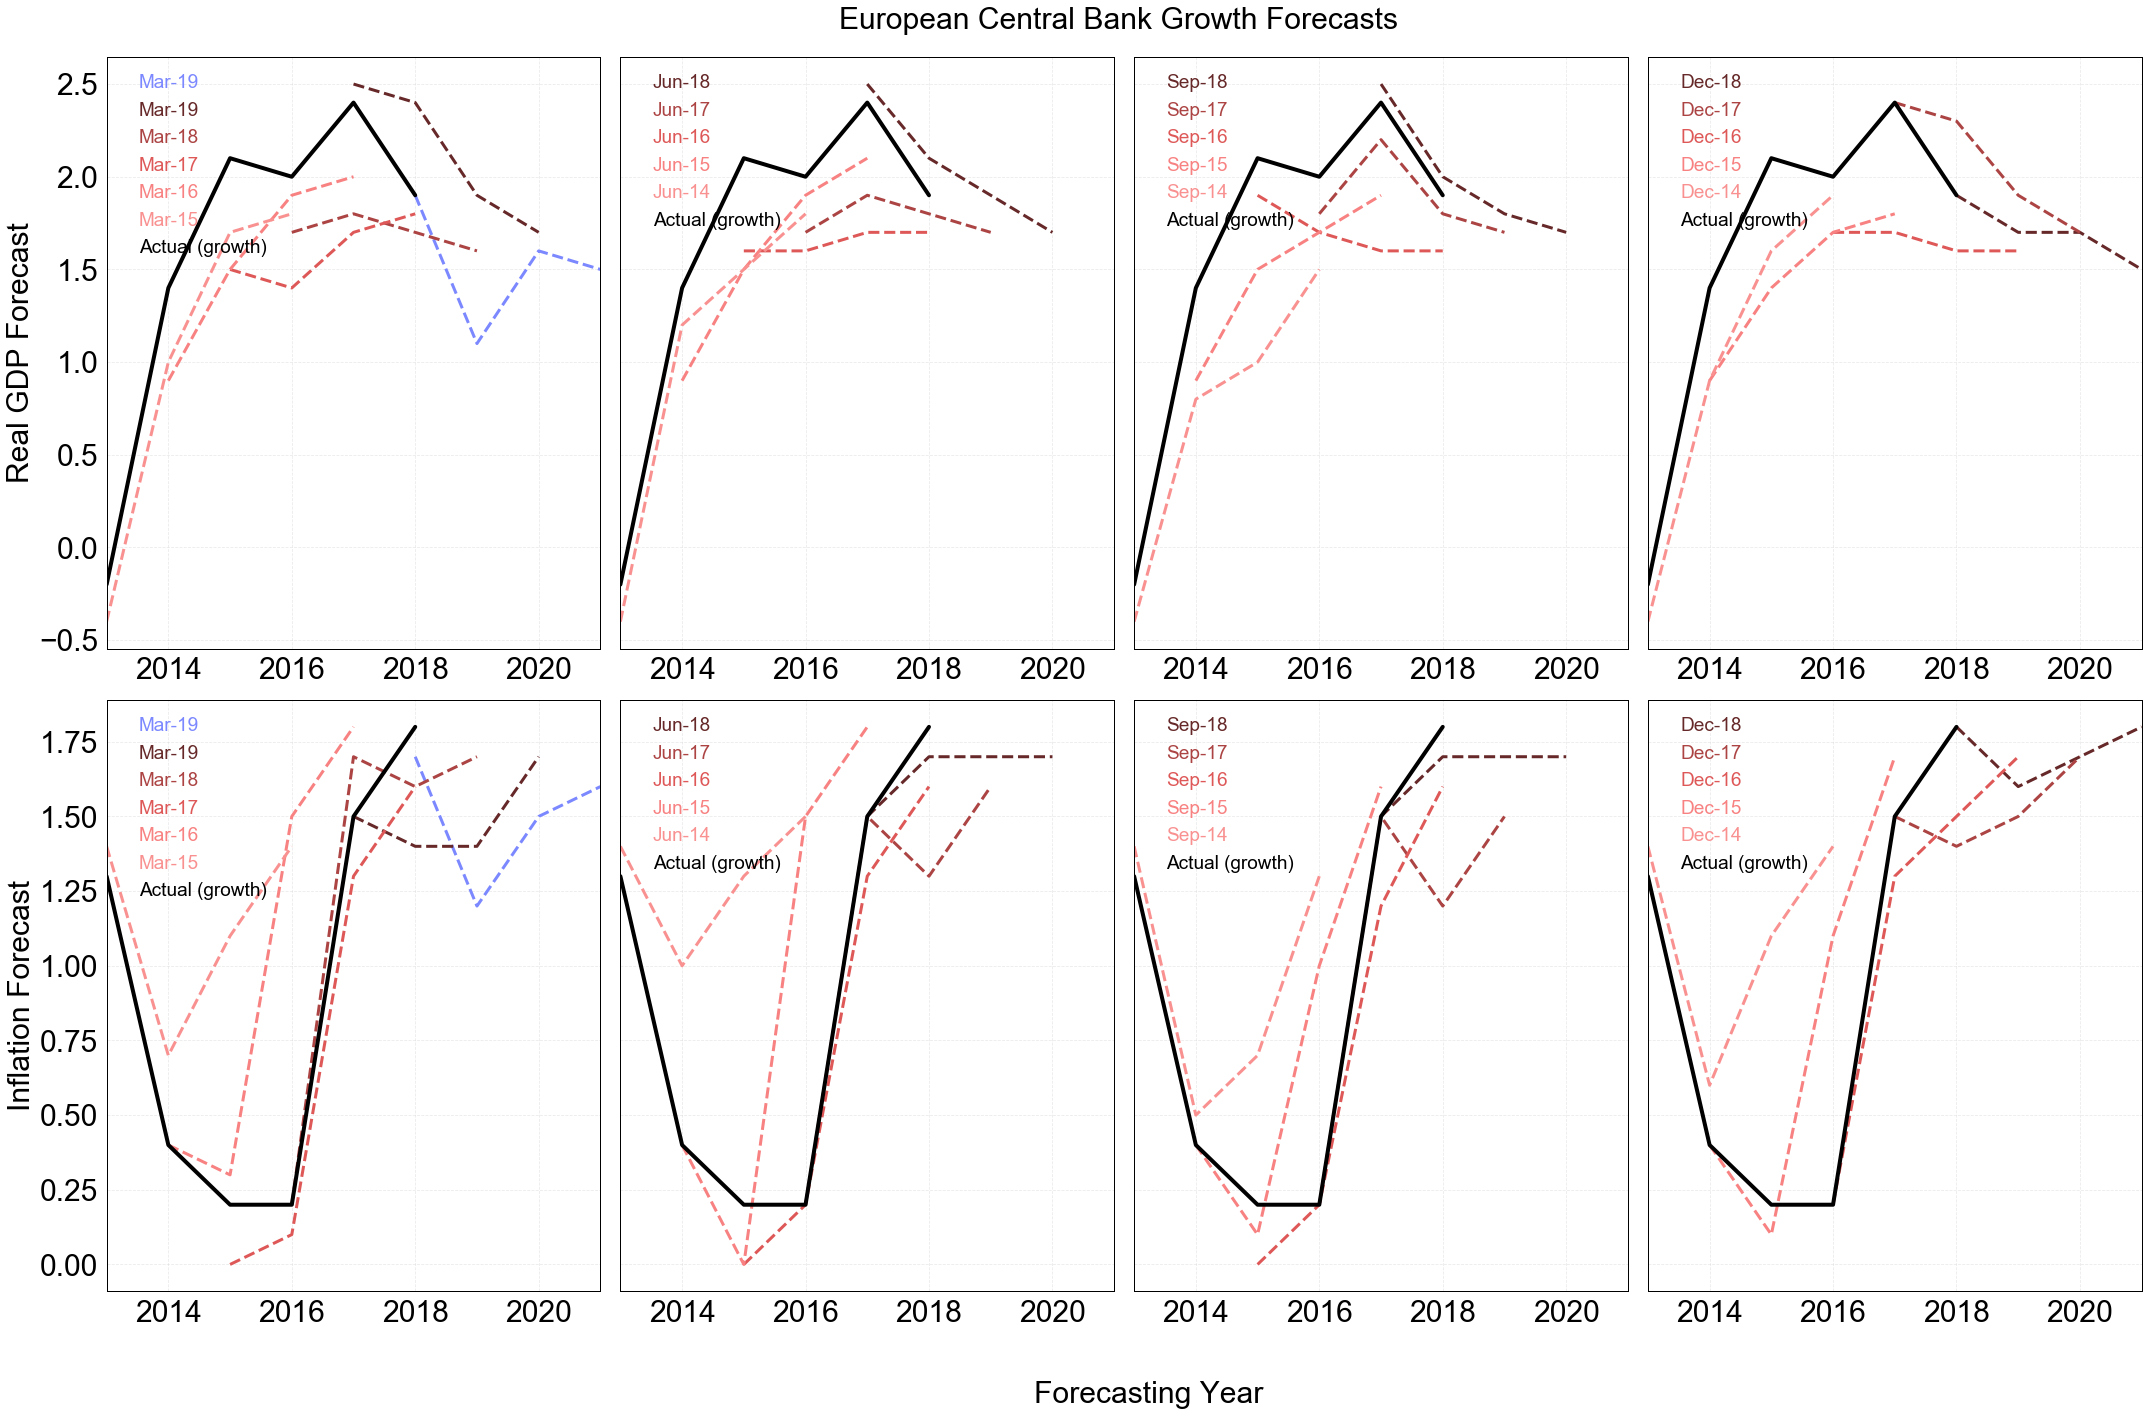

In [21]:
fig, axs = plt.subplots(2,4, figsize=(30, 18), sharey='row', sharex='row')
ax = axs.flatten()

year = ['19','18','17','16','15','14']
year_18 = ['18','17','16','15','14']
month = ['Mar','Jun','Sep','Dec']
colours = ['#fddfdf','#fccfcf','#fbb0b0','#f99191','#f88181','#de5858','#ac4444','#662828']
arr = np.array(colours)
reversed_arr = arr[::-1]  
line_wid=3

## 2019 Data
ax[0].plot(df.forecast_year[0:4], df.real_gdp[0:4],linestyle='--', c='#7b88ff', linewidth=line_wid,label=f'{month[0]}-{year[0]}')
ax[4].plot(df.forecast_year[0:4], df.hicp[0:4],linestyle='--', c='#7b88ff', linewidth=line_wid,label=f'{month[0]}-{year[0]}')

i=16
m=4
n=8
k=12
j=0
while i<len(df):
    ax[0].plot(df.forecast_year[i:i+4], df.real_gdp[i:i+4], linestyle='--', c=reversed_arr[j], linewidth=line_wid, label=f'{month[0]}-{year[j]}')
    ax[1].plot(df.forecast_year[n:n+4], df.real_gdp[n:n+4], linestyle='--', c=reversed_arr[j], linewidth=line_wid, label=f'{month[1]}-{year_18[j]}')        
    ax[2].plot(df.forecast_year[k:k+4], df.real_gdp[k:k+4], linestyle='--', c=reversed_arr[j], linewidth=line_wid, label=f'{month[2]}-{year_18[j]}')            
    ax[3].plot(df.forecast_year[m:m+4], df.real_gdp[m:m+4], linestyle='--', c=reversed_arr[j], linewidth=line_wid, label=f'{month[-1]}-{year_18[j]}')    
    ax[4].plot(df.forecast_year[i:i+4], df.hicp[i:i+4], linestyle='--', c=reversed_arr[j], linewidth=line_wid, label=f'{month[0]}-{year[j]}')
    ax[5].plot(df.forecast_year[n:n+4], df.hicp[n:n+4], linestyle='--', c=reversed_arr[j], linewidth=line_wid, label=f'{month[1]}-{year_18[j]}')        
    ax[6].plot(df.forecast_year[k:k+4], df.hicp[k:k+4], linestyle='--', c=reversed_arr[j], linewidth=line_wid, label=f'{month[2]}-{year_18[j]}')            
    ax[7].plot(df.forecast_year[m:m+4], df.hicp[m:m+4], linestyle='--', c=reversed_arr[j], linewidth=line_wid, label=f'{month[-1]}-{year_18[j]}')        
    i+=16
    n+=16
    k+=16
    m+=16
    j+=1  

## Actual Euro Area Real GDP
for i in range(0,4):
    ax[i].plot(actual_year, actual_real_gdp,linewidth=4, c='black',label='Actual (growth)') 
    
for i in range(4,8):
    ax[i].plot(actual_year, actual_hicp,linewidth=4, c='black',label='Actual (growth)') 
    

for a in ax[:]:        
    a.grid(linestyle='dashed', alpha=0.4)
    a.autoscale(enable=True, axis='x', tight=True)
    leg=a.legend(loc='upper left', fontsize=19, framealpha=0, ncol=1,handlelength=0, mode='expand')
    for line,text in zip(leg.get_lines(), leg.get_texts()):
        text.set_color(line.get_color()) 

ax[0].set_ylabel('Real GDP Forecast')
ax[4].set_ylabel('Inflation Forecast')
        
fig.text(0.39, 1.01, 'European Central Bank Growth Forecasts', fontsize=30)
fig.text(0.48, -0.05, 'Forecasting Year', fontsize=30)
        
plt.tight_layout()
plt.savefig("ECB_forecasts.png", dpi=300, bbox_inches='tight', transparent=True)
plt.savefig("ECB_forecasts.pdf", bbox_inches='tight', transparent=True)
